# Bounding box detection - Pneumonia data

## Import the necessary libraries

In [ ]:
import numpy as np
import pandas as pd
np.random.seed(1)
import os
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf
from keras import Model
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from keras.utils import Sequence
from keras.backend import epsilon
from keras.layers import Dense, Dropout, Flatten

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Change directory

In [ ]:
import os
os.chdir('/content/drive/My Drive/aiml_course/pneumonia_detection/rsna-pneumonia-detection-challenge/rsna-pneumonia-detection-challenge/jpegs')

In [ ]:
! ls

0.zip  1.zip  2_stage_2_train_labels.csv  pneumonia_images_pragna


In [ ]:
#!unzip -q -o 1.zip -d pneumonia_images_pragna
#!unzip -q -o 0.zip -d pneumonia_images_0

### Load the training data from train.csv file

In [ ]:
train = pd.read_csv("/content/drive/My Drive/aiml_course/pneumonia_detection/rsna-pneumonia-detection-challenge/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv")

### Print the shape of the train dataset

In [ ]:
train.shape

(30227, 6)

### Print the head of the dataset

In [ ]:
train.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [ ]:
train['filename'] = train['patientId']+".jpg"

In [ ]:
train.head()

,patientId,x,y,width,height,Target,filename
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,0004cfab-14fd-4e49-80ba-63a80b6bddd6.jpg
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,00313ee0-9eaa-42f4-b0ab-c148ed3241cd.jpg
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,00322d4d-1c29-4943-afc9-b6754be640eb.jpg
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,003d8fa0-6bf1-40ed-b54c-ac657f8495c5.jpg
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,00436515-870c-4b36-a041-de91049b9ab4.jpg


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
 6   filename   30227 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 1.6+ MB


### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [ ]:
IMAGE_SIZE = 128

### Load the train.csv file data and store the path, width, height, x0,y0,x1,y1 in individual variables. <br>
1. Create a list variable known as 'paths' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images


In [ ]:
paths = []
coords = np.zeros(((len(train[train.Target==1])), 4))
#coords = np.zeros(((len(train)), 4))
i = 0 
for index, row in train[train.Target==1].iterrows():
#for index, row in train.iterrows():    
  #path, x, y, wid, ht, class_ 
    #print (x, y, w, h, path)
    if (row['Target']==1):
        x = row['x']
        y = row['y']
        w = row['width']
        h = row['height']
        path= 'pneumonia_images_pragna/1'+os.path.sep+row['filename']
    else: 
        x =0 
        y=0
        w=0
        h=0 
        path= 'pneumonia_images_0/0'+os.path.sep+row['filename']
    coords[i,0] = x * IMAGE_SIZE / 1024
    coords[i,1] = y * IMAGE_SIZE / 1024
    coords[i,2] = (x+w) * IMAGE_SIZE / 1024 # Normalize bounding box by image size
    coords[i,3] = (y+h) * IMAGE_SIZE / 1024
    paths.append(path) 
    #print(coords[i,0]*8,coords[i,1]*8, coords[i,2]*8-coords[i,0]*8, coords[i,3]*8-coords[i,1]*8, paths[i])  
    #print(coords[4,0],coords[4,1], coords[4,2], coords[4,3], paths[4])
    i=i+1       

In [ ]:
print(len(paths))

9555


In [ ]:
#random.seed(42)

#random_path = random.shuffle(paths)
#random_coords = random.shuffle(coords)

#val_size = 1500
#paths_val = random_path[:val_size]
#paths_train = random_path[val_size:]

#coords_val = random_path[:val_size]
#coords_train = random_path[val_size:]


#print(len(image_fps_train), len(image_fps_val))

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [ ]:
from PIL import Image
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)

for i, f in enumerate(paths):
    if (i%100 ==0 ):
      print(i)
    img = Image.open('/content/drive/My Drive/aiml_course/pneumonia_detection/rsna-pneumonia-detection-challenge/rsna-pneumonia-detection-challenge/jpegs/'+ f) # Read image
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
    img = img.convert('RGB')
    batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))
      

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500


### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [ ]:
ALPHA = 1.0

In [ ]:
model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA) # Load pre-trained mobilenet
# Do not include classification (top) layer

# to freeze layers, except the new top layer, of course, which will be added below
for layer in model.layers:
    layer.trainable = False

# Add new top layer which is a conv layer of the same size as the previous layer so that only 4 coords of BBox can be output
x = model.layers[-1].output

#Add Fully Connected Layer with 128 units and activation function as 'ReLU'
x = Dense(128, activation='relu',name='dense_1')(x)

#Apply Dropout with 0.5 probability 
x = Dropout(0.5,name='drop_2')(x)

x = Conv2D(4, kernel_size=4, name="coords")(x)
# In the line above kernel size should be 3 for img size 96, 4 for img size 128, 5 for img size 160 etc.
x = Reshape((4,))(x) # These are the 4 predicted coordinates of one BBox

model = Model(inputs=model.input, outputs=x)

17227776/17225924 [==============================] - 2s 0us/step


In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128 

### Define a custom loss function IoU which calculates Intersection Over Union

In [ ]:
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_function(loss, [y_true, y_pred], tf.float32)
    return iou

In [ ]:
PATIENCE = 10

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [ ]:
gt = coords
len(batch_images)
print(len(coords))
model.compile(optimizer='Adam', loss='mse', metrics=[IoU]) # Regression loss is MSE

checkpoint = ModelCheckpoint("model-{val_iou:.2f}.h5", verbose=2, save_best_only=True,
                              save_weights_only=True, mode="max", period=1) # Checkpoint best validation model
stop = EarlyStopping(monitor="val_iou", patience=PATIENCE, mode="max") # Stop early, if the validation error deteriorates
reduce_lr = ReduceLROnPlateau(monitor="val_iou", factor=0.2, patience=10, min_lr=1e-7, verbose=1, mode="max")
# Reduce learning rate if Validation IOU does not improve

model.fit( batch_images[1500:],gt[1500:], epochs=30,batch_size = 32, verbose=2, validation_data=(batch_images[:1500],gt[:1500]))



9555
Train on 8055 samples, validate on 1500 samples
Epoch 1/30
 - 31s - loss: 632.1478 - IoU: 0.2571 - val_loss: 470.5272 - val_IoU: 0.2686
Epoch 2/30
 - 23s - loss: 453.5983 - IoU: 0.2780 - val_loss: 552.2789 - val_IoU: 0.2518
Epoch 3/30
 - 24s - loss: 437.2873 - IoU: 0.2868 - val_loss: 606.5452 - val_IoU: 0.2621
Epoch 4/30
 - 24s - loss: 424.8058 - IoU: 0.2929 - val_loss: 496.4524 - val_IoU: 0.2624
Epoch 5/30
 - 23s - loss: 417.0655 - IoU: 0.2947 - val_loss: 496.2999 - val_IoU: 0.2604
Epoch 6/30
 - 24s - loss: 404.9372 - IoU: 0.3001 - val_loss: 475.7100 - val_IoU: 0.2670
Epoch 7/30
 - 24s - loss: 400.9875 - IoU: 0.3034 - val_loss: 466.5931 - val_IoU: 0.2698
Epoch 8/30
 - 24s - loss: 390.3448 - IoU: 0.3068 - val_loss: 498.1987 - val_IoU: 0.2640
Epoch 9/30
 - 24s - loss: 387.0310 - IoU: 0.3105 - val_loss: 468.2559 - val_IoU: 0.2713
Epoch 10/30
 - 24s - loss: 382.3751 - IoU: 0.3112 - val_loss: 460.0516 - val_IoU: 0.2717
Epoch 11/30
 - 24s - loss: 383.5525 - IoU: 0.3126 - val_loss: 507.

In [ ]:
history = model.history.history

In [ ]:
epochs = range(1,len(next(iter(history.values())))+1)
pd.DataFrame(history, index=epochs)

,val_loss,val_IoU,loss,IoU
1,470.527223,0.268570,632.147790,0.257060
2,552.278915,0.251783,453.598340,0.277953
3,606.545220,0.262066,437.287337,0.286777
4,496.452389,0.262436,424.805765,0.292882
5,496.299917,0.260385,417.065503,0.294687
6,475.710000,0.266981,404.937186,0.300076
7,466.593133,0.269843,400.987524,0.303404
8,498.198652,0.264023,390.344765,0.306753
9,468.255910,0.271257,387.031010,0.310502
10,460.051584,0.271681,382.375105,0.311227


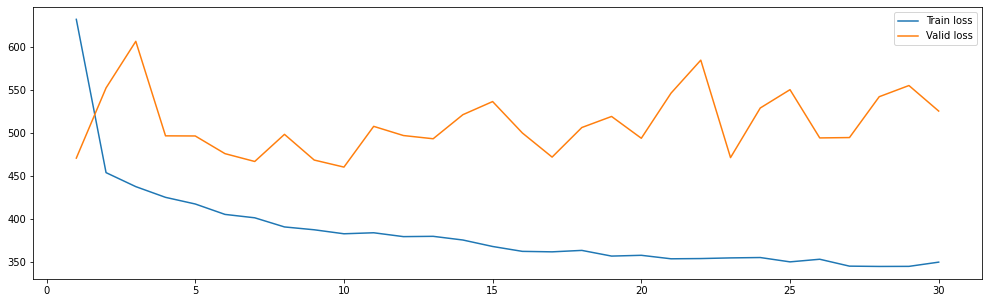

In [ ]:
plt.figure(figsize=(17,5))

plt.subplot(111)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()

plt.show()

### Pick a test image from the given data

In [ ]:
# Pick a test image, run model, show image, and show predicted bounding box overlaid on the image
import cv2
filename = '/content/drive/My Drive/aiml_course/pneumonia_detection/rsna-pneumonia-detection-challenge/rsna-pneumonia-detection-challenge/jpegs/pneumonia_images_pragna/1/0a0f91dc-6015-4342-b809-d19610854a21.jpg'
unscaled = cv2.imread(filename) # Original image for display

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [ ]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) # Rescaled image to run the network
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [ ]:
region = model.predict(x=np.array([feat_scaled]))[0] # Predict the BBox

In [ ]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

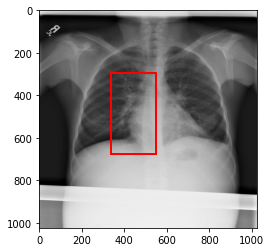

In [ ]:
# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()